# import libraries

In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import re
from galvani import BioLogic

from function import read_mpr

import pymysql
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.widgets import Slider,CheckButtons

from scipy.signal import savgol_filter,filtfilt,butter,find_peaks

from tqdm import tqdm


# import raw data to MySQL

## read mpr files to pandas dataframe

### read Formation data

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#load data from folder
df_form = read_mpr.mpr_pandas('raw_data/form')

In [4]:
read_mpr.searchmpr('raw_data/form')

['raw_data/form\\Cell001_Form_20uA_25T_30RH_Cycle1to10_01_GEIS_CA1.mpr',
 'raw_data/form\\Cell001_Form_20uA_25T_30RH_Cycle1to10_02_GCPL_CA1.mpr',
 'raw_data/form\\Cell001_Form_20uA_25T_30RH_Cycle1to10_03_GEIS_CA1.mpr',
 'raw_data/form\\Cell001_Form_20uA_25T_30RH_Cycle1to10_04_GCPL_CA1.mpr',
 'raw_data/form\\Cell002_Form_20uA_25T_30RH_Cycle1to10_01_GEIS_CA2.mpr',
 'raw_data/form\\Cell002_Form_20uA_25T_30RH_Cycle1to10_02_GCPL_CA2.mpr',
 'raw_data/form\\Cell002_Form_20uA_25T_30RH_Cycle1to10_03_GEIS_CA2.mpr',
 'raw_data/form\\Cell002_Form_20uA_25T_30RH_Cycle1to10_04_GCPL_CA2.mpr',
 'raw_data/form\\Cell003_Form_50uA_25T_30RH_Cycle1to10_01_GEIS_CA3.mpr',
 'raw_data/form\\Cell003_Form_50uA_25T_30RH_Cycle1to10_02_GCPL_CA3.mpr',
 'raw_data/form\\Cell003_Form_50uA_25T_30RH_Cycle1to10_03_GEIS_CA3.mpr',
 'raw_data/form\\Cell003_Form_50uA_25T_30RH_Cycle1to10_04_GCPL_CA3.mpr',
 'raw_data/form\\Cell004_Form_50uA_25T_30RH_Cycle1to10_01_GEIS_CA4.mpr',
 'raw_data/form\\Cell004_Form_50uA_25T_30RH_Cycle1t

In [5]:
df_form[3]

,flags,Ns,time/s,dQ/mA.h,(Q-Qo)/mA.h,control/V/mA,Ewe/V,I Range,Q charge/discharge/mA.h,half cycle,loop_Nr,cycle_Nr
0,23,0,1.411805e+05,-1.855859e-10,-1.855859e-10,0.00,2.097619,115,-1.855859e-10,0,0,1
1,23,0,1.411855e+05,0.000000e+00,-1.855859e-10,0.00,2.094193,115,-1.855859e-10,0,0,1
2,7,0,1.411906e+05,0.000000e+00,-1.855859e-10,-0.02,2.073522,117,-1.855859e-10,0,0,1
3,33,1,1.411906e+05,-1.112816e-08,-1.131375e-08,-0.02,2.073010,117,-1.131375e-08,0,0,1
4,1,1,1.411956e+05,-2.781651e-05,-2.782783e-05,-0.02,2.032771,117,-2.782783e-05,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
265690,7,1,2.311430e+06,0.000000e+00,-2.214351e-01,0.00,0.010400,115,-2.864958e+00,0,9,10
265691,7,1,2.311435e+06,0.000000e+00,-2.214351e-01,0.00,0.010361,115,-2.864958e+00,0,9,10
265692,7,1,2.311440e+06,0.000000e+00,-2.214351e-01,0.00,0.010322,115,-2.864958e+00,0,9,10
265693,7,1,2.311445e+06,0.000000e+00,-2.214351e-01,0.00,0.010440,115,-2.864958e+00,0,9,10


#### add serval columns

In [6]:
# list paths of data in .mpr file
datafilespath = glob('raw_data/form/*.mpr')
datafilespath =  [os.path.basename(x) for x in datafilespath]

In [7]:
datafilespath

['Cell001_Form_20uA_25T_30RH_Cycle1to10_01_GEIS_CA1.mpr',
 'Cell001_Form_20uA_25T_30RH_Cycle1to10_02_GCPL_CA1.mpr',
 'Cell001_Form_20uA_25T_30RH_Cycle1to10_03_GEIS_CA1.mpr',
 'Cell001_Form_20uA_25T_30RH_Cycle1to10_04_GCPL_CA1.mpr',
 'Cell002_Form_20uA_25T_30RH_Cycle1to10_01_GEIS_CA2.mpr',
 'Cell002_Form_20uA_25T_30RH_Cycle1to10_02_GCPL_CA2.mpr',
 'Cell002_Form_20uA_25T_30RH_Cycle1to10_03_GEIS_CA2.mpr',
 'Cell002_Form_20uA_25T_30RH_Cycle1to10_04_GCPL_CA2.mpr',
 'Cell003_Form_50uA_25T_30RH_Cycle1to10_01_GEIS_CA3.mpr',
 'Cell003_Form_50uA_25T_30RH_Cycle1to10_02_GCPL_CA3.mpr',
 'Cell003_Form_50uA_25T_30RH_Cycle1to10_03_GEIS_CA3.mpr',
 'Cell003_Form_50uA_25T_30RH_Cycle1to10_04_GCPL_CA3.mpr',
 'Cell004_Form_50uA_25T_30RH_Cycle1to10_01_GEIS_CA4.mpr',
 'Cell004_Form_50uA_25T_30RH_Cycle1to10_02_GCPL_CA4.mpr',
 'Cell004_Form_50uA_25T_30RH_Cycle1to10_03_GEIS_CA4.mpr',
 'Cell004_Form_50uA_25T_30RH_Cycle1to10_04_GCPL_CA4.mpr',
 'Cell005_Form_100uA_25T_30RH_Cycle1to10_01_GEIS_CA5.mpr',
 'Cell005_For

##### half cycle and state of charge

In [8]:
#set half cycle of discharge processes to 1 in gcpl
#ds[3,7,11...]
discharge_index = np.arange(3,np.shape(datafilespath)[0],4)
for index in discharge_index:
    df_form[index]['half cycle']=1
#set state of charge in geis
cell_empty_index = np.arange(0,np.shape(datafilespath)[0],4)
cell_full_index = np.arange(2,np.shape(datafilespath)[0],4)
for index in cell_empty_index:
    df_form[index]['state of charge']=0
for index in cell_full_index:
    df_form[index]['state of charge']=1

In [9]:
discharge_index = np.arange(3,np.shape(datafilespath)[0],4)
discharge_index

array([ 3,  7, 11, 15, 19, 23, 27, 31])

### read Cycling data

In [10]:
df_cycle = read_mpr.mpr_pandas('raw_data/cycle')

In [11]:
df_cycle[0]

,freq/Hz,Re(Z)/Ohm,-Im(Z)/Ohm,|Z|/Ohm,Phase(Z)/deg,time/s,Ewe/V,I/mA,Cs/µF,Cp/µF,cycle number,|Ewe|/V,|I|/A,I Range,cycle_Nr
0,10001.000000,139.493546,71.365753,156.689240,-27.094564,6.334000e+00,0.022527,0.000030,0.222991,0.046258,0.0,0.000743,0.000005,117,11
1,6740.000000,158.397385,76.452881,175.882843,-25.764980,1.260600e+01,0.021819,0.003522,0.308863,0.058359,0.0,0.000858,0.000005,117,11
2,4541.999512,178.573685,83.481094,197.123444,-25.055536,1.886800e+01,0.022724,0.000949,0.419744,0.075281,0.0,0.000971,0.000005,117,11
3,3061.000977,201.583359,91.200615,221.254166,-24.343012,2.513000e+01,0.023433,0.000613,0.570110,0.096866,0.0,0.001094,0.000005,117,11
4,2063.000488,227.392685,98.029236,247.623032,-23.320927,3.032600e+01,0.023709,-0.004434,0.786983,0.123337,0.0,0.001151,0.000005,117,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.048894,1594.901489,350.710052,1633.005859,-12.401653,4.020468e+06,-0.005506,-0.004338,9281.377930,428.088348,0.0,0.007759,0.000005,117,41
140,0.032596,1677.474365,387.407990,1721.628662,-13.004297,4.020621e+06,-0.005821,-0.004342,12603.273438,638.177612,0.0,0.008138,0.000005,117,41
141,0.020955,1795.079346,444.867950,1849.382935,-13.918968,4.020848e+06,0.000045,-0.002350,17072.863281,987.904419,0.0,0.008605,0.000005,117,41
142,0.013970,1888.072144,478.563934,1947.778198,-14.223048,4.021185e+06,0.011897,0.004569,23806.128906,1437.109009,0.0,0.009278,0.000005,117,41


In [13]:
cyc_files = glob('raw_data/cycle/*.mpr')
for file in cyc_files:
    try:
        BioLogic.MPRfile(file)
    except:
        print('files: '+file+' is unreadable')

similar issue: https://github.com/echemdata/galvani/issues/39

# import dataframes to Mysql

## Structure 1(deprecated):    
cell001:     
-step01_geis    
-step02_gcpl    
-step03_geis    
-step04_gcpl    

In [206]:
##structure 1
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'

Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword)
print('connection succeed')


cursor = Connection.cursor()
cursor.execute('DROP DATABASE IF EXISTS cell_configuration;')
cursor.execute('CREATE DATABASE cell_configuration;')

##cell configuration
engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db='cell_configuration', user=dbuser, pw=dbpassword))
read_mpr.filename_read(datafilespath).to_sql('cell_configuration', engine, if_exists='fail',index=False)
print('table cell_configuration created')

Cell_ID = np.unique([x.split('_')[0] for x in datafilespath])
Unique_Index = np.append(np.unique([x.split('_')[0] for x in datafilespath],return_index=True)[1],len(df_form))
Tech_Type = [x.split('_')[-2].lower() for x in datafilespath]

##labor data
for i in range(len(Cell_ID)):
    cursor.execute('DROP DATABASE IF EXISTS '+Cell_ID[i])
    cursor.execute('CREATE DATABASE '+Cell_ID[i])
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=Cell_ID[i], user=dbuser, pw=dbpassword))
    step_ID = [x.split('_')[-3] for x in datafilespath]
    # capacity
    
    for j in range(Unique_Index[i],Unique_Index[i+1]):
        if step_ID[j]=='02':
            df_form[j].to_sql('step'+step_ID[j]+'_'+'charge', engine, if_exists='fail',index=False)
        elif step_ID[j]=='04':
            df_form[j].to_sql('step'+step_ID[j]+'_'+'discharge', engine, if_exists='fail',index=False)
        else:
            df_form[j].to_sql('step'+step_ID[j]+'_'+Tech_Type[j], engine, if_exists='fail',index=False)
            
        print('table '+'step'+step_ID[j]+'_'+Tech_Type[j]+' of '+Cell_ID[i]+' created')
        
print('All data loaded')


connection succeed
table cell_configuration created
table step01_geis of Cell001 created
table step02_gcpl of Cell001 created
table step03_geis of Cell001 created
table step04_gcpl of Cell001 created


KeyboardInterrupt: 

## Structure 2:    
cell001:    
-geis    
-gcpl    

In [14]:
#structure 2
#We prefer this structure!
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'

Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword)
print('connection succeed')


cursor = Connection.cursor()
cursor.execute('DROP DATABASE IF EXISTS cell_configuration;')
cursor.execute('CREATE DATABASE cell_configuration;')

##cell configuration
engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db='cell_configuration', user=dbuser, pw=dbpassword))
read_mpr.filename_read(datafilespath).to_sql('cell_configuration', engine, if_exists='fail',index=False)
print('table cell_configuration created')

Cell_ID = np.unique([x.split('_')[0] for x in datafilespath])
Unique_Index = np.append(np.unique([x.split('_')[0] for x in datafilespath],return_index=True)[1],len(df_form))
Tech_Type = [x.split('_')[-2].lower() for x in datafilespath]

print('='*100+'\nForm data:')
##formation labor data
for i in range(len(Cell_ID)):
    cursor.execute('DROP DATABASE IF EXISTS '+Cell_ID[i])
    cursor.execute('CREATE DATABASE '+Cell_ID[i])
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=Cell_ID[i], user=dbuser, pw=dbpassword))
    step_ID = [x.split('_')[-3] for x in datafilespath]
    
    geis_data_index=[]
    for j in range(Unique_Index[i],Unique_Index[i+1]):
        if j in np.where(np.array(Tech_Type)== 'geis')[0]:
            geis_data_index = np.append(geis_data_index,j)
    geis_data = pd.concat([df_form[int(k)] for k in geis_data_index],ignore_index=True)
    geis_data=geis_data.sort_values(by=['time/s'])
    geis_data.to_sql('form_geis', engine, if_exists='fail',index=False)
    print('geis data of '+Cell_ID[i]+ ' loaded')
    
    gcpl_data_index=[]
    for j in range(Unique_Index[i],Unique_Index[i+1]):
        
        if j in np.where(np.array(Tech_Type)== 'gcpl')[0]:
            gcpl_data_index = np.append(gcpl_data_index,j)
    gcpl_data = pd.concat([df_form[int(k)] for k in gcpl_data_index],ignore_index=True)
    gcpl_data=gcpl_data.sort_values(by=['time/s'])
    gcpl_data.to_sql('form_gcpl', engine, if_exists='fail',index=False)    
    print('gcpl data of '+Cell_ID[i]+ ' loaded')    

    
print('='*100+'\nCycl data:')
##cycling labor data   
db=np.unique([x.split('_')[0] for x in datafilespath])
for cell,index in zip(db,range(0,16,2)):
    Connection = pymysql.connect(host=dbhost,
                                  port=dbport,
                                  user=dbuser,
                                  password=dbpassword,
                                  database=cell)   
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=cell, user=dbuser, pw=dbpassword))
    df_cycle[index].to_sql('cyc_geis', engine, if_exists='replace',index=False)
    print('geis data of '+cell+ ' loaded')
    df_cycle[index+1].to_sql('cyc_gcpl', engine, if_exists='replace',index=False)
    print('gcpl data of '+cell+ ' loaded')
    
print('='*100)
print('All data loaded')


connection succeed
table cell_configuration created
Form data:
geis data of Cell001 loaded
gcpl data of Cell001 loaded
geis data of Cell002 loaded
gcpl data of Cell002 loaded
geis data of Cell003 loaded
gcpl data of Cell003 loaded
geis data of Cell004 loaded
gcpl data of Cell004 loaded
geis data of Cell005 loaded
gcpl data of Cell005 loaded
geis data of Cell006 loaded
gcpl data of Cell006 loaded
geis data of Cell007 loaded
gcpl data of Cell007 loaded
geis data of Cell008 loaded
gcpl data of Cell008 loaded
Cycl data:
geis data of Cell001 loaded
gcpl data of Cell001 loaded
geis data of Cell002 loaded
gcpl data of Cell002 loaded
geis data of Cell003 loaded
gcpl data of Cell003 loaded
geis data of Cell004 loaded
gcpl data of Cell004 loaded
geis data of Cell005 loaded
gcpl data of Cell005 loaded
geis data of Cell006 loaded
gcpl data of Cell006 loaded
geis data of Cell007 loaded
gcpl data of Cell007 loaded
geis data of Cell008 loaded
gcpl data of Cell008 loaded
All data loaded


# Savitzky-Golay filter

## charge/discharge curve

In [42]:
# query data from MySQL
##cell001, gcpl, structure 2
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
db='cell001'

Connection = pymysql.connect(host=dbhost,
                          port=dbport,
                          user=dbuser,
                          password =dbpassword,
                          database=db)
# structure 1
# ## charge step
# sql = 'SELECT `(Q-Qo)/mA.h`,`Ewe/V`, `time/s` from step02_charge'
# cursor = Connection.cursor()
# cursor.execute(sql)

# charge = cursor.fetchall()
# charge = np.array(charge)
# ##discharge step
# sql = 'SELECT `(Q-Qo)/mA.h`,`Ewe/V`, `time/s` from step04_discharge'
# cursor.execute(sql)

# discharge = cursor.fetchall()
# discharge = np.array(discharge)

# structue 2
sql = 'SELECT `Q charge/discharge/mA.h`,`Ewe/V`, `time/s` FROM cyc_gcpl'
cursor = Connection.cursor()
cursor.execute(sql)
curve = cursor.fetchall()
curve = np.array(curve)

<IPython.core.display.Javascript object>


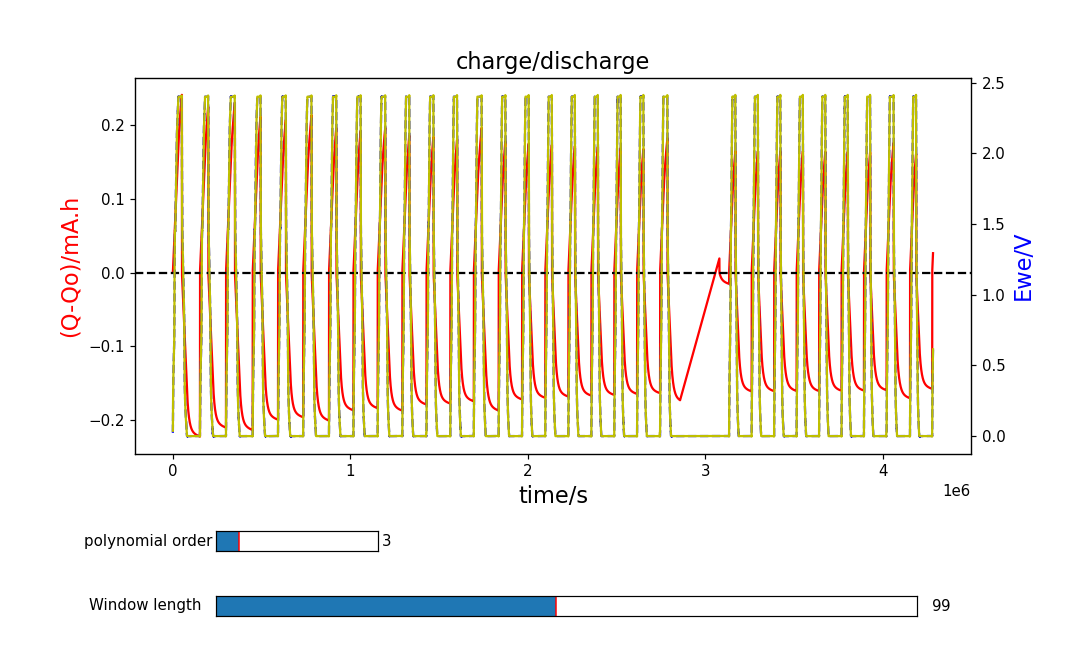

In [43]:
# curve=np.concatenate((charge,discharge))
# curve=curve[curve[:, 2].argsort()]
%matplotlib notebook
## plot curves
fig,ax = plt.subplots(figsize=(10,6))
plt.subplots_adjust(bottom=0.3)
ax.set_title('charge/discharge',fontsize=15)
ax.plot(curve[:,2], curve[:,0], color="red")
#ax.plot(charge[:,2], charge[:,0], color="red")
#ax.plot(discharge[:,2], -discharge[:,0], color="yellow")
ax.axhline(0,color='black',linestyle='--')
ax.set_xlabel("time/s",fontsize=15)
ax.set_ylabel("(Q-Qo)/mA.h",color="red",fontsize=15)

ax2=ax.twinx()
ax2.plot(curve[:,2], curve[:,1],"b--")
ax2.set_ylabel("Ewe/V",color="blue",fontsize=15)


p, = ax2.plot(curve[:,2], savgol_filter(curve[:,1],111,3), "y")

## define the slides
ax_slide1 = plt.axes([0.2,0.05,0.65,0.03])
ax_slide2 = plt.axes([0.2,0.15,0.15,0.03])

## properties of slides
win_len = Slider(ax_slide1,'Window length', valmin = 5,valmax = 199,valinit = 99,valstep = 2)
p_order = Slider(ax_slide2,'polynomial order', valmin = 2,valmax = 9,valinit = 3,valstep = 1)

## updating function
def update(val):
    current_win_len = int(win_len.val)
    current_p_order = int(p_order.val)
    p.set_ydata(savgol_filter(curve[:,1],current_win_len,current_p_order))
    fig.canvas.draw()
    
win_len.on_changed(update)
p_order.on_changed(update)

plt.show()


# cell capacity
create a table of each cell to discribe its capacity in all loops

In [20]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
db=np.unique([x.split('_')[0] for x in datafilespath])

for cell in db:
    Connection = pymysql.connect(host=dbhost,
                                  port=dbport,
                                  user=dbuser,
                                  password=dbpassword,
                                  database=cell)
    #formation
    sql = 'SELECT `(Q-Qo)/mA.h`,`cycle_Nr`, `half cycle` FROM ' +cell+ '.form_gcpl'
    cellx_df = pd.read_sql(sql, Connection)
    cycle_Nr = np.unique(cellx_df['cycle_Nr'])
    charge=[]
    discharge=[]
    for cycle in cycle_Nr:
        charge.append(cellx_df[(cellx_df['cycle_Nr']==cycle) & (cellx_df['half cycle']==0)]['(Q-Qo)/mA.h'].max())
        discharge.append(cellx_df[(cellx_df['cycle_Nr']==cycle) & (cellx_df['half cycle']==1)]['(Q-Qo)/mA.h'].min())
    capacity_form = {'cycle_Nr':cycle_Nr,'Q_charge':charge,'Q_discharge':discharge,'CE/%':np.round(np.divide(np.abs(discharge),charge)*100,2)}
    capacity_form['cycle type'] = 'Formation'
    capacity_form = pd.DataFrame(data=capacity_form)


    
    #cycling
    sql = 'SELECT `(Q-Qo)/mA.h`,`cycle_Nr`, `half cycle` FROM ' +cell+ '.cyc_gcpl'
    cellx_df = pd.read_sql(sql, Connection)
    cycle_Nr = np.unique(cellx_df['cycle_Nr'])
    charge=[]
    discharge=[]
    for cycle in cycle_Nr:
        charge.append(cellx_df[(cellx_df['cycle_Nr']==cycle) & (cellx_df['half cycle']==0)]['(Q-Qo)/mA.h'].max())
        discharge.append(cellx_df[(cellx_df['cycle_Nr']==cycle) & (cellx_df['half cycle']==1)]['(Q-Qo)/mA.h'].min())
    capacity_cycle = {'cycle_Nr':cycle_Nr,'Q_charge':charge,'Q_discharge':discharge,'CE/%':np.round(np.divide(np.abs(discharge),charge)*100,2)}
    capacity_cycle['cycle type'] = 'Cycling'
    capacity_cycle = pd.DataFrame(data=capacity_cycle,index=cycle_Nr)
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=cell, user=dbuser, pw=dbpassword))
    
    capacity = pd.concat([capacity_form,capacity_cycle])
    stop
    capacity.to_sql('capacity', engine, if_exists='replace',index=False)
    print('table capacity of '+cell +' created')

NameError: name 'stop' is not defined

In [21]:
capacity

,cycle_Nr,Q_charge,Q_discharge,CE/%,cycle type
0,1,0.629991,-3.159484e-01,50.15,Formation
1,2,0.672673,-3.496181e-01,51.97,Formation
2,3,0.528947,-3.572950e-01,67.55,Formation
3,4,0.414435,-3.207878e-01,77.40,Formation
4,5,0.352402,-2.916898e-01,82.77,Formation
5,6,0.321627,-2.732722e-01,84.97,Formation
6,7,0.299554,-2.575941e-01,85.99,Formation
7,8,0.280395,-2.446975e-01,87.27,Formation
8,9,0.262684,-2.326199e-01,88.56,Formation
9,10,0.246246,-2.214351e-01,89.92,Formation


In [31]:
cellx_df[(cellx_df['cycle_Nr']==15) & (cellx_df['half cycle']==1)]['(Q-Qo)/mA.h']

127376    0.206953
127377    0.206926
127378    0.206898
127379    0.206870
127380    0.206842
            ...   
146849    0.011018
146850    0.011018
146851    0.000000
146852    0.000000
146853    0.000000
Name: (Q-Qo)/mA.h, Length: 19478, dtype: float64

In [24]:
cellx_df

,(Q-Qo)/mA.h,cycle_Nr,half cycle
0,-2.589719e-10,11,0
1,-2.589719e-10,11,0
2,-2.589719e-10,11,0
3,1.083685e-08,11,0
4,2.774418e-05,11,0
...,...,...,...
811406,2.618630e-02,42,0
811407,2.621404e-02,42,0
811408,2.624178e-02,42,0
811409,2.626952e-02,42,0


# $V$,$\frac {dV}{dt}$,$\frac{d(\frac {dV}{dt})}{dt}$ vs. time

In [55]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
db=np.unique([x.split('_')[0] for x in datafilespath])
v_dV_ddV_time=[]
for cell in db:
    Connection = pymysql.connect(host=dbhost,
                                  port=dbport,
                                  user=dbuser,
                                  password=dbpassword,
                                  database=cell)

    sql = 'SELECT `Ewe/V`,`time/s`,`half cycle`,`loop_Nr` FROM ' +cell+ '.form_gcpl'
    cellx_df = pd.read_sql(sql, Connection)

    V = cellx_df['Ewe/V']
    #savgol_filter
    win_len = 179
    p_order = 3
    V_sg = savgol_filter(V,win_len,p_order)
    
    t =cellx_df['time/s']
    half_cycle = cellx_df['half cycle']
    loop_Nr = cellx_df['loop_Nr']
    
    #with savgol_filter
    dV_sg = np.divide(np.diff(V_sg,append=-1),np.diff(t,append=-1))
#     ddV_sg = np.divide(np.diff(dV_sg,append=-1),np.diff(t,append=-1))
    #without savgpl_filter
    dV = np.divide(np.diff(V,append=-1),np.diff(t,append=-1))
#     ddV = np.divide(np.diff(dV,append=-1),np.diff(t,append=-1))
    #apply filter twice
#     ddV_sgsg = savgol_filter(ddV,win_len,p_order)
    
    
    
    derivative_of_v_to_time = {'V':V,'V_sg':V_sg,'dV':dV,'dV_sg':dV_sg,'t':t,'half cycle':half_cycle,'loop_Nr':loop_Nr}
    derivative_of_v_to_time = pd.DataFrame(data=derivative_of_v_to_time)    
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=cell, user=dbuser, pw=dbpassword))
    derivative_of_v_to_time.to_sql('derivative_of_v_to_time', engine, if_exists='replace',index=False)
    print('table derivative_of_v_to_time of '+cell +' created')

table derivative_of_v_to_time of Cell001 created
table derivative_of_v_to_time of Cell002 created
table derivative_of_v_to_time of Cell003 created
table derivative_of_v_to_time of Cell004 created
table derivative_of_v_to_time of Cell005 created
table derivative_of_v_to_time of Cell006 created
table derivative_of_v_to_time of Cell007 created
table derivative_of_v_to_time of Cell008 created


In [97]:
# connection
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
cell='cell001'
Connection = pymysql.connect(host=dbhost,
                              port=dbport,
                              user=dbuser,
                              password=dbpassword,
                              database=cell)

# query from Mysql
sql = 'SELECT * FROM ' +cell+ '.derivative_of_v_to_time'
cellx_df = pd.read_sql(sql, Connection)
sql = 'SELECT `(Q-Qo)/mA.h` FROM ' +cell+ '.gcpl'
Q = pd.read_sql(sql, Connection)

print('data queried')
V = cellx_df['V'].copy()
V_sg = cellx_df['V_sg'].copy()
t = cellx_df['t'].copy()
dV = cellx_df['dV'].copy()
dV_sg = cellx_df['dV_sg'].copy()
# ddV = cellx_df['ddV'].copy()
# ddV_sg = cellx_df['ddV_sg'].copy()
# ddV_sgsg = cellx_df['ddV_sgsg'].copy()
half_cycle = cellx_df['half cycle'].copy()
loop_Nr = cellx_df['loop_Nr'].copy()

data queried


In [98]:
def find_extreme_point(dV_sg,half_cycle,loop_Nr):
    '''
    this func helps find all extreme points in the whole curve
    afterwards some should be filtered
    dV_sg should be continuous
    '''
    index=[]
    for loop in np.unique(loop_Nr):
        for soc in np.unique(half_cycle):
            tmp = dV_sg[(half_cycle==soc)&(loop_Nr==loop)].copy()
            if soc == 1:tmp = -tmp# discharge phase
            num_peaks = find_peaks(tmp, prominence =0.00005) 
            index = np.append(index,(num_peaks[0]+tmp.dropna().index[0]))
    return [int(i) for i in index]


point_index = find_extreme_point(dV_sg,half_cycle,loop_Nr)

In [99]:
def remove_constant_V(dV,dV_sg):
    '''
    when V = 2.4 or 0(constant, actual value c.a. 2.399 and -0.0003) remove the impact of these sections of time 
    in this case dV/dt is 0 and doesn't make sense
    '''

    dV.loc[V>2.398]=np.nan
    dV.loc[V<-0.00001]=np.nan
    dV_sg.loc[V_sg>2.398]=np.nan
    dV_sg.loc[V_sg<-0.00001]=np.nan


    nan_mask = np.ma.clump_masked(np.ma.masked_invalid(dV_sg))

    for ma in nan_mask:
        ma = np.r_[ma]
        if ma[0]-100 <0:
            ma = np.append(np.array(range(0,ma[0])),ma)
        else:
            ma = np.append(np.array(range(ma[0]-100,ma[0])),ma)
        ma = np.append(ma,np.array(range(ma[-1],ma[-1]+100)))
        dV.loc[ma] = np.nan
        dV_sg.loc[ma] = np.nan
    return dV,dV_sg


dV,dV_sg = remove_constant_V(dV,dV_sg)

In [100]:

def remove_EIS(dV,dV_sg):
    # in dV and ddV, remove the data in EIS phases

    ## get the time points of all eis processes
    sql = 'SELECT `time/s`,`loop_Nr`,`state of charge` FROM ' +cell+ '.geis'
    eis_time = pd.read_sql(sql, Connection)
    time=[]
    for ln in np.unique(eis_time['loop_Nr']):
        for soc in np.unique(eis_time['state of charge']):
            start = eis_time.loc[(eis_time['loop_Nr']==ln) & (eis_time['state of charge']==soc)]['time/s'].min()
            end = eis_time.loc[(eis_time['loop_Nr']==ln) & (eis_time['state of charge']==soc)]['time/s'].max()
            time = np.append(time,[start,end])

    time=time.reshape((-1,2))

    ## in dV and ddV, replace with np.nan
    delta_t = 800
    for start,end in time:
        dV.loc[(t>start-3*delta_t)&(t<end+delta_t)] = np.nan
        dV_sg.loc[(t>start-3*delta_t)&(t<end+delta_t)] = np.nan
    #     ddV.loc[(t>start-delta_t)&(t<end+delta_t)] = np.nan
    #     ddV_sg.loc[(t>start-3*delta_t)&(t<end+delta_t)] = np.nan



    # just delete the time between removed phase and eis phase,as Q change almost not
    mask_unnan=np.ma.clump_unmasked(np.ma.masked_invalid(dV_sg))
    for loop in np.unique(loop_Nr):
        for soc in np.unique(half_cycle):
            #only do it if 2 sections in the array
            if len(mask_unnan)==4*len(np.unique(loop_Nr)):
                if soc == 0:
                    dV.loc[mask_unnan[1+4*loop]]=np.nan
                    dV_sg.loc[mask_unnan[1+4*loop]]=np.nan
                elif soc == 1:
                    dV.loc[mask_unnan[3+4*loop]]=np.nan
                    dV_sg.loc[mask_unnan[3+4*loop]]=np.nan
                else:
                    raise ValueError('soc should be either 0 or 1')
            else:
                break
    return dV,dV_sg


dV,dV_sg = remove_EIS(dV,dV_sg)

<IPython.core.display.Javascript object>


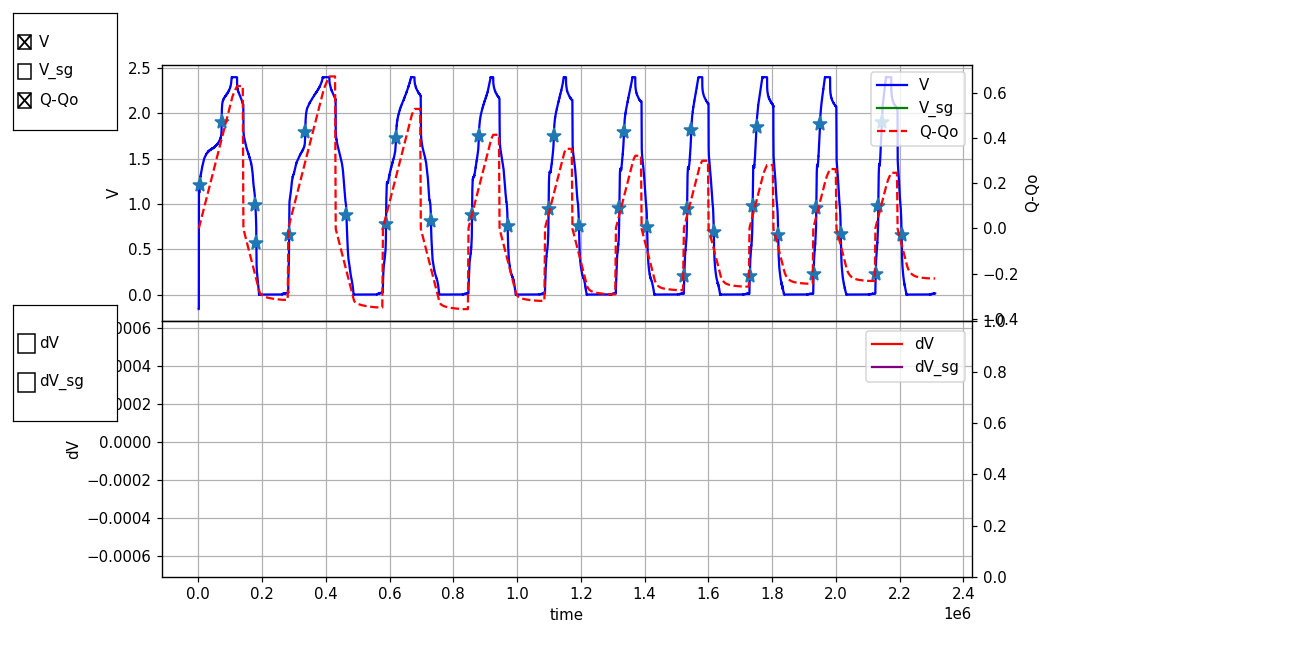

In [101]:
#plot the curves
%matplotlib notebook
## axis

fig,ax = plt.subplots(2,1,figsize=(12,6), sharex=True)
fig.subplots_adjust(right=0.75,top=0.9,hspace=.0)


ax[0].grid()
ax[1].grid()
ax1=ax[0].twinx()
ax2=ax[1].twinx()
ax[0].locator_params(axis='x', nbins=15)

#plot curves
p1,=ax[0].plot(t,V, color="blue", label='V',visible=True)
p1_sg,= ax[0].plot(t,V_sg, color="green", label='V_sg',visible=True)
q, = ax1.plot(t,Q, color="red",linestyle='--', label='Q-Qo',visible=True)
p2,=ax[1].plot(t,dV, color="red", label='dV',visible=True)
p2_sg,=ax[1].plot(t,dV_sg, color="purple", label='dV_sg',visible=True)
# p3,=ax2.plot(t,ddV, color="orange", label='ddV',visible=True)
# p3_sg,=ax2.plot(t,ddV_sg, color="grey", label='ddV_sg',visible=True)
# p3_sgsg,=ax2.plot(t,ddV_sgsg, color="yellow", label='ddV_sgsg',visible=True)

#plot points
# index = find_extreme_point(dV_sg,half_cycle,loop_Nr)
index,_=find_peaks(dV_sg, prominence =0.00005) 
invalid_point_index =np.argwhere(np.isnan([dV_sg[i] for i in point_index]))
point_index = np.delete(point_index, invalid_point_index)
point_dV = ax[1].plot(t[point_index], [dV_sg[i] for i in point_index],'*',markersize=10,visible=True)
point_V = ax[0].plot(t[point_index], [V[i] for i in point_index],'*',markersize=10,visible=True)

#set visible
fig.legend([p1,p1_sg,q],['V','V_sg','Q-Qo'],bbox_to_anchor=(0.75, 0.9))
fig.legend([p2,p2_sg],['dV','dV_sg'],bbox_to_anchor=(0.75, 0.5))
p1_sg.set_visible(False)
p2.set_visible(False)
p2_sg.set_visible(False)
# p3.set_visible(False)
# p3_sg.set_visible(False)
# p3_sgsg.set_visible(False)
point_dV[0].set_visible(False)
point_V[0].set_visible(True)

#x labels
ax[1].set_xlabel("time")
ax[0].set_ylabel("V")
ax1.set_ylabel("Q-Qo")
ax[1].set_ylabel("dV")
# ax2.set_ylabel("ddV")


## define the checkboxes
ax_cb1 = plt.axes([0.01,0.8,0.08,0.18])
ax_cb2 = plt.axes([0.01,0.35,0.08,0.18])

## properties of checkboxes
cbs1 = CheckButtons(ax_cb1,['V','V_sg','Q-Qo'],actives=[True,False,True])
cbs2 = CheckButtons(ax_cb2,['dV','dV_sg'],actives=[False,False])
## updating function
def update(val):
    status1 = cbs1.get_status()
    status2 = cbs2.get_status()
    p1.set_visible(status1[0])
    p1_sg.set_visible(status1[1])
    q.set_visible(status1[2])
    p2.set_visible(status2[0])
    p2_sg.set_visible(status2[1])
    point_dV[0].set_visible(status2[1])
#     p3.set_visible(status2[2])
#     p3_sg.set_visible(status2[3])
#     p3_sgsg.set_visible(status2[4])
    
    fig.canvas.draw()
    
cbs1.on_clicked(update)
cbs2.on_clicked(update)

plt.show()

## transfer points info to Mysql

In [112]:
# connection
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
db=np.unique([x.split('_')[0] for x in datafilespath])

for cell in db:
    
    Connection = pymysql.connect(host=dbhost,
                                  port=dbport,
                                  user=dbuser,
                                  password=dbpassword,
                                  database=cell)

    # query from Mysql
    sql = 'SELECT * FROM ' +cell+ '.derivative_of_v_to_time'
    cellx_df = pd.read_sql(sql, Connection)
    sql = 'SELECT `(Q-Qo)/mA.h` FROM ' +cell+ '.gcpl'
    Q = pd.read_sql(sql, Connection)
    Q = Q['(Q-Qo)/mA.h'].copy()

    print('{} data queried'.format(cell))
    V = cellx_df['V'].copy()
    V_sg = cellx_df['V_sg'].copy()
    t = cellx_df['t'].copy()
    dV = cellx_df['dV'].copy()
    dV_sg = cellx_df['dV_sg'].copy()
    half_cycle = cellx_df['half cycle'].copy()
    loop_Nr = cellx_df['loop_Nr'].copy()
    
    # find the points and filter them
    point_index = find_extreme_point(dV_sg,half_cycle,loop_Nr)
    dV,dV_sg = remove_constant_V(dV,dV_sg)
    dV,dV_sg = remove_EIS(dV,dV_sg)
    index,_=find_peaks(dV_sg, prominence =0.00005) 
    invalid_point_index =np.argwhere(np.isnan([dV_sg[i] for i in point_index]))
    point_index = np.delete(point_index, invalid_point_index)
    points = {'t':t[point_index].values,'V':V[point_index].values,'Q':Q[point_index].values,
              'half cycle':half_cycle[point_index].values,'loop_Nr':loop_Nr[point_index].values }
    points = pd.DataFrame(data=points)
    engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=cell, user=dbuser, pw=dbpassword))
    points.to_sql('research_points', engine, if_exists='replace',index=False)
    print('table research_points of '+cell +' created')



Cell001 data queried
table research_points of Cell001 created
Cell002 data queried
table research_points of Cell002 created
Cell003 data queried
table research_points of Cell003 created
Cell004 data queried
table research_points of Cell004 created
Cell005 data queried
table research_points of Cell005 created
Cell006 data queried
table research_points of Cell006 created
Cell007 data queried
table research_points of Cell007 created
Cell008 data queried
table research_points of Cell008 created


# $V$,$\frac {dV}{dQ}$,$\frac{d(\frac {dV}{dQ})}{dQ}$ vs. Q

In [18]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
# db=np.unique([x.split('_')[0] for x in datafilespath])
v_dV_ddV_Q=[]
cell='Cell005'
Connection = pymysql.connect(host=dbhost,
                              port=dbport,
                              user=dbuser,
                              password=dbpassword,
                              database=cell)

sql = 'SELECT `Ewe/V`,`(Q-Qo)/mA.h`,`loop_Nr` FROM ' +cell+ '.gcpl'
cellx_df = pd.read_sql(sql, Connection)

V = cellx_df['Ewe/V']
loop = cellx_df['loop_Nr']
#savgol_filter
win_len = 179
p_order = 3
V_sg = savgol_filter(V,win_len,p_order)

Q =cellx_df['(Q-Qo)/mA.h']
#     dV = np.divide(np.diff(V_sg,append=-1),np.diff(Q,append=-1))
#     ddV = np.divide(np.diff(dV,append=-1),np.diff(Q,append=-1))
#     v_dV_ddV_Q = {'V':V,'V_sg':V_sg,'dV':dV,'ddV':ddV,'Q':Q}
#     v_dV_ddV_Q = pd.DataFrame(data=v_dV_ddV_Q)    
#     engine =create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}".format(host=dbhost, db=cell, user=dbuser, pw=dbpassword))
#     v_dV_ddV_Q.to_sql('v_dv_ddv_q', engine, if_exists='replace',index=False)
#     print('table v_dv_ddv_q of '+cell +' created')

## $V$ vs. Q

<IPython.core.display.Javascript object>


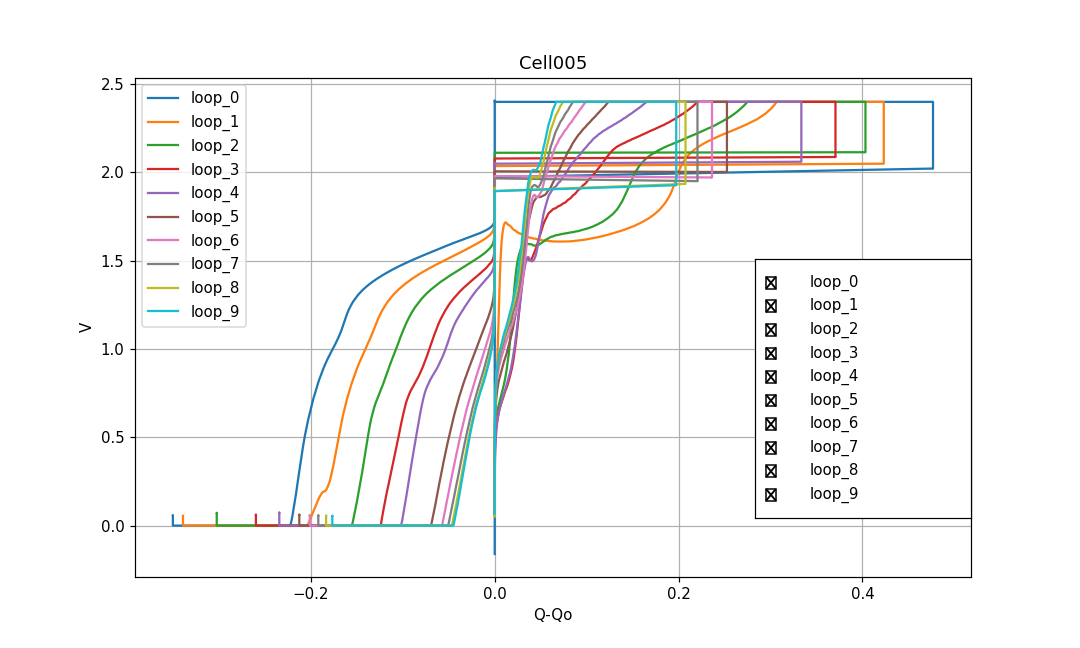

0

In [19]:
fig,ax = plt.subplots(figsize=(10,6))
plt.title(cell)
l = ax.plot(
    Q[loop==0],V[loop==0],
    Q[loop==1],V[loop==1],
    Q[loop==2],V[loop==2],
    Q[loop==3],V[loop==3],
    Q[loop==4],V[loop==4],
    Q[loop==5],V[loop==5],
    Q[loop==6],V[loop==6],
    Q[loop==7],V[loop==7],
    Q[loop==8],V[loop==8],
    Q[loop==9],V[loop==9]
       )
ax.legend(['loop_0','loop_1','loop_2','loop_3','loop_4','loop_5','loop_6','loop_7','loop_8','loop_9'])
ax.set_xlabel("Q-Qo")
ax.set_ylabel("V")
ax.grid()
## define the checkboxes
ax_cb = plt.axes([0.7,0.2,0.2,0.4])
cbs = CheckButtons(ax_cb,['loop_0','loop_1','loop_2','loop_3','loop_4','loop_5','loop_6','loop_7','loop_8','loop_9'],
                    actives=[True,True,True,True,True,True,True,True,True,True])

## updating function
def update(val):
    status = cbs.get_status()
    l[0].set_visible(status[0])
    l[1].set_visible(status[1])
    l[2].set_visible(status[2])
    l[3].set_visible(status[3])
    l[4].set_visible(status[4])
    l[5].set_visible(status[5])
    l[6].set_visible(status[6])
    l[7].set_visible(status[7])
    l[8].set_visible(status[8])
    l[9].set_visible(status[9])
    fig.canvas.draw()
cbs.on_clicked(update)

In [245]:
dV_sgsg

array([-2.22694453e-05, -2.14681256e-05, -2.06747560e-05, ...,
        3.81631839e-05,  3.82287265e-05,  3.82945210e-05])

In [253]:
dV_sgsg[14161]

0.0003180761375953368

## $\frac {dV}{dQ}$vs. Q

<IPython.core.display.Javascript object>


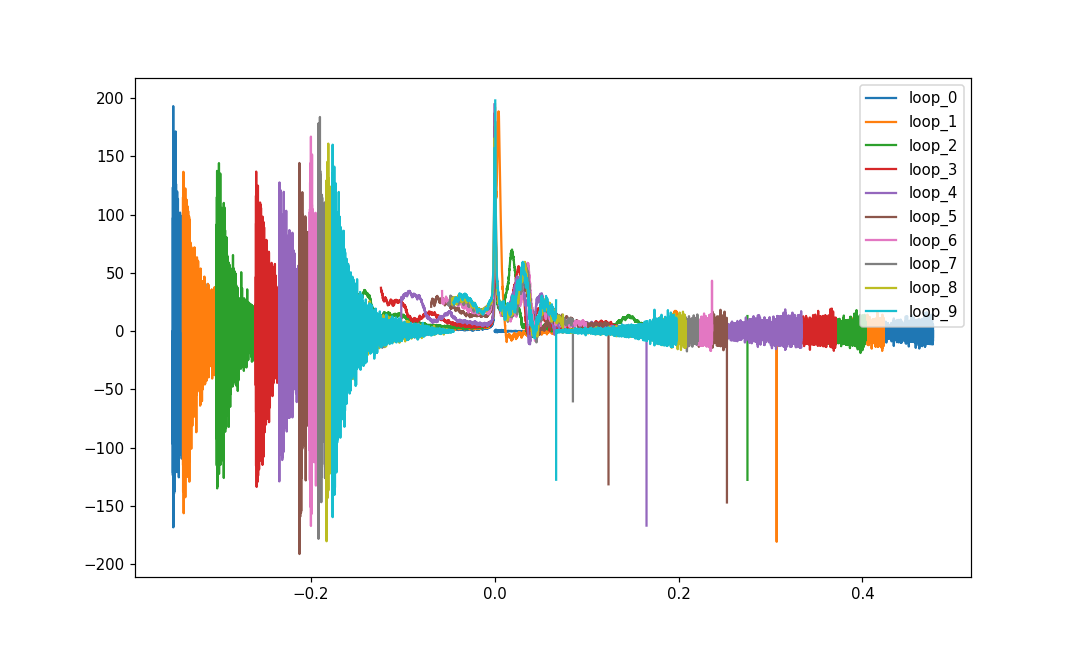

In [20]:
fig,ax = plt.subplots(figsize=(10,6))
l=[]
#savgol_filter
win_len = 179
p_order = 3
for i in range(0,10):
    dV = np.diff(V[loop==i],append=-1)
    dQ = np.diff(Q[loop==i],append=-1)
    dVdQ = np.zeros(dV.shape)
    idxNonZeros = np.where(dQ!=0)
    idxZeros = np.where(dQ==0)
    dVdQ[idxNonZeros] = dV[idxNonZeros]/dQ[idxNonZeros]
    dVdQ[idxZeros] = np.nan
    
    dVdQ[abs(dVdQ)>=200]=np.nan
    
    l = ax.plot(Q[loop==i],dVdQ)
ax.legend(['loop_0','loop_1','loop_2','loop_3','loop_4','loop_5','loop_6','loop_7','loop_8','loop_9'])

# EIS

In [4]:
dbhost='127.0.0.1'
dbport=3306
dbuser='root'
dbpassword='yaoyue0320'
connection_name='EIS'
v_dV_ddV_Q=[]
cell='Cell001'
Connection = pymysql.connect(host=dbhost,
                              port=dbport,
                              user=dbuser,
                              password=dbpassword,
                              database=cell)

sql = 'SELECT `freq/Hz`,`Re(Z)/Ohm`,`-Im(Z)/Ohm`,`loop_Nr`,`state of charge` FROM ' +cell+ '.geis'
cellx_df = pd.read_sql(sql, Connection)
f =np.array(cellx_df[(cellx_df['loop_Nr']==0) & (cellx_df['state of charge']==1)]['freq/Hz'])
Z = np.array(cellx_df[(cellx_df['loop_Nr']==0) & (cellx_df['state of charge']==1)][['Re(Z)/Ohm','-Im(Z)/Ohm']])
Z = Z[:, 0] - 1j*Z[:, 1]

In [196]:
len(np.ma.clump_unmasked(np.ma.masked_invalid(dV_sg)))

40

In [199]:
4*len(np.unique(loop_Nr))

40

In [155]:
t[np.ma.clump_unmasked(np.ma.masked_invalid(dV_sg[(half_cycle==0) & (loop_Nr==0)]))[1]]

24030    121799.171942
24031    121804.171943
24032    121809.171943
24033    121814.171943
24034    121819.171943
             ...      
27087    137084.173036
27088    137089.173036
27089    137094.173037
27090    137099.173037
27091    137104.173038
Name: t, Length: 3062, dtype: float64

In [151]:
dV_sg

0                  NaN
1                  NaN
2                  NaN
3                  NaN
4                  NaN
              ...     
455453    6.866695e-07
455454    6.923428e-07
455455    7.105750e-07
455456    6.067659e-05
455457    4.371331e-07
Name: dV_sg, Length: 455458, dtype: float64

In [138]:
dV_sg[t<time[1,0]]

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
27567   NaN
27568   NaN
27569   NaN
27570   NaN
27571   NaN
Name: dV_sg, Length: 27572, dtype: float64

<IPython.core.display.Javascript object>


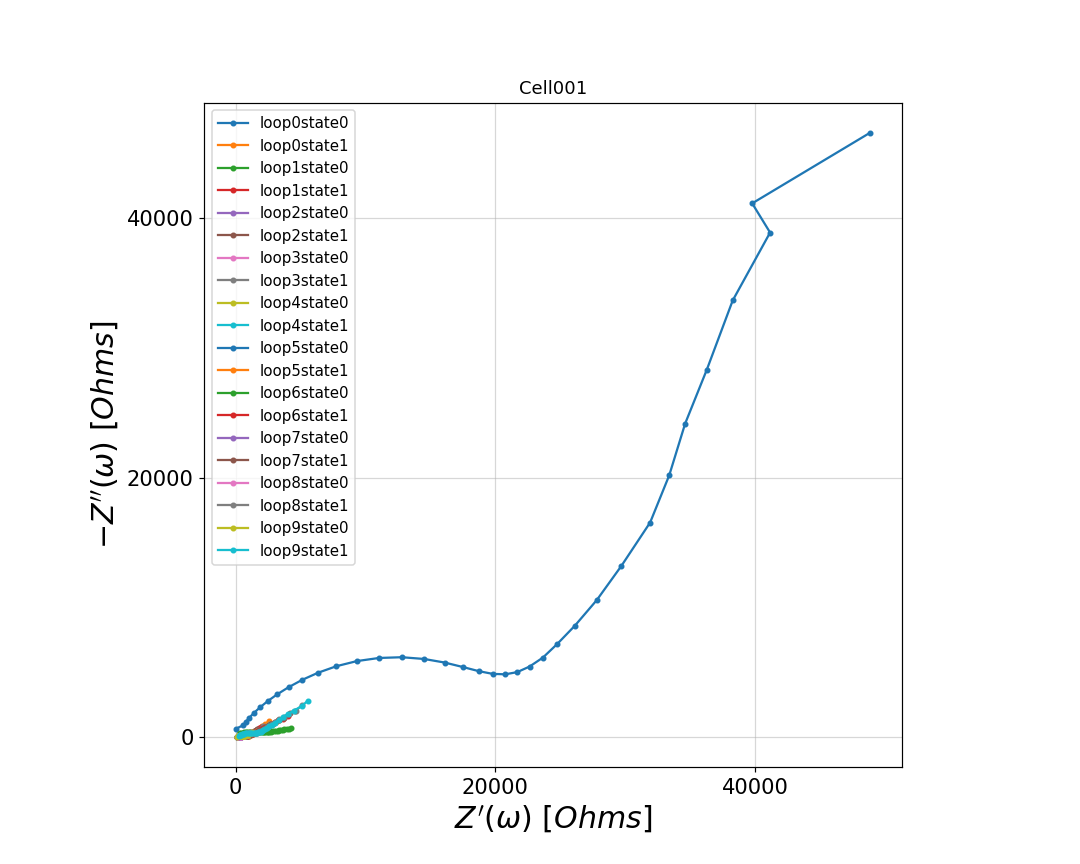

In [6]:
from impedance.visualization import plot_nyquist
from impedance import preprocessing
%matplotlib notebook
f, Z = preprocessing.ignoreBelowX(f, Z)
fig, ax = plt.subplots(figsize=(10,8))
plt.title(cell)
Legend = []
for i in np.unique(cellx_df['loop_Nr']):
    for j in np.unique(cellx_df['state of charge']):
        f =np.array(cellx_df[(cellx_df['loop_Nr']==i) & (cellx_df['state of charge']==j)]['freq/Hz'])
        Z = np.array(cellx_df[(cellx_df['loop_Nr']==i) & (cellx_df['state of charge']==j)][['Re(Z)/Ohm','-Im(Z)/Ohm']])
        Z = Z[:, 0] - 1j*Z[:, 1]
        plot_nyquist(ax, Z)
        Legend = np.append(Legend,'loop'+str(i)+'state'+str(j))
ax.legend(Legend)

In [112]:
np.where(np.isnan(V_sg[t<time[1,0]]))


(array([], dtype=int64),)